# Projet Python WordCloud - ENSAE 1A

## 1. Introduction

L’objectif est d’observer l’évolution de la crise du coronavirus à travers l’analyse des discours de Macron. Il s’agira donc d’extraire les mots clés de ces discours (*text clouds*). Pour cela, il nous faudra coder en Python un wordcloud.

Il y a plusieurs méthodes pour coder un wordcloud i.e. un algorithme qui extrait les mots clés d’un texte :

1) La plus simple est de faire un **ranking des mots utilisés en fonction de leur fréquence d’apparition** : cette méthode naïve présente l’inconvénient d’accorder une importance démesurée aux petits mots (« de », « et », etc). On peut alors les supprimer en important des **stopwords**.

2) On peut aussi pondérer les fréquences d’apparition des mots en fonction d’une moyenne de leur apparition dans un corpus de textes représentatifs de l’usage usuel de ces mots. C’est **la méthode TF-IDF**.

3) Il s’agira ensuite d’étudier plus en détail d’autres éléments qui peuvent aider à obtenir un ranking des mots en fonction de leur importance dans le discours. On va se concentrer sur **la racinisation** (*stemming*).

## 2. L'importation des packages nécessaires.

Cela peut prendre un peu de temps...

In [1]:
import nltk
import numpy
import matplotlib
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
import unicodedata
import re
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download fr_core_news_sm
import fr_core_news_sm
nlp = fr_core_news_sm.load()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('french'))
stop_words.add('les')
stop_words.add('a')
stop_words.add("l'")
stop_words.add("d'")
stop_words.add("c'")
stop_words.add("m'")
stop_words.add("n'")
stop_words.add("s'")
stop_words.add("t'")
stop_words.add("j'")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer(language='french')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


## 3. Le nettoyage du texte

Il faut enregistrer le fichier au format .txt dans le même fichier que le document au format .ipynb.

Nous avons étudié plusieurs méthodes de nettoyage du texte que nous détaillons ci-dessous.

### 3.1. Première version du nettoyage

La fonction clean_text1 prend un texte de discours au format txt et sort le texte nettoyé en format liste. Il s'agit de la première fonction que l'on a créée. Elle présente de nombreux défauts : 

   1) la fonction enlève les accents et annule tous les mots composés,
   
   2) les stopwords que l'on a importés à partir du package nltk ne permettent pas un traitement du texte parfait,

   3) le lemmatizer n'est pas maîtrisé.

A ce stade le texte est donc grossièrement nettoyé, restent les problèmes des accents, des mots composés et du lemmatizer.

In [2]:
def cleaner_text1(discours):
    
    # on importe le texte enregistré au format txt dans le même fichier que ce notebook
    discours = f'./{discours}.txt'
    with open(discours,'r') as f:
        data = f.read()

    # on rend le texte plus facile à traiter (on met en minuscule et on enlève les caractères parasites)
    data = data.lower()
    pattern = r'[^a-zA-z0-9\s]'
    data = re.sub(pattern, '', data)
    
    # on importe les stopwords
    stop_words = set(stopwords.words('french'))
    stop_words.add('les')
    stop_words.add('a')
    stop_words.add('aussi')
    stop_words.add('plus')
    
    # on tokénise le texte en prenant en compte les stopwords
    data_tokens = nltk.word_tokenize(data)
    words = [w for w in data_tokens if not w in stop_words]
    
    # on racinise le texte avec une fonction automatique du package nltk
    words_lemmatize = nltk.WordNetLemmatizer()
    
    # on retourne une liste contenant tous les mots après traitement
    return [words_lemmatize.lemmatize(t) for t in words]

On essaye ici avec les premières lignes du discours prononcé par E. Macron le 31 mars.

In [12]:
cleaner_text1("discoursmacron31mars")[:10]

['bonjour',
 'toutes',
 'tous',
 'voulais',
 'madresser',
 'depuis',
 'lusine',
 'kolmihopen',
 'saintbarthlmydanjou',
 'dire']

### 3.2. Deuxième version du nettoyage.

La fonction cleaner_text2 prend en appel le nom d'un texte (au format .txt) et retourne le texte nettoyé et racinisé

In [13]:
# Fonctions auxiliaires :

def replace_caractere(texte): # remplacer des caractères spéciaux lié au traitement de texte
    s = list(texte)
    for i in range(len(s)):
        if  s[i] == "’":
            s[i] = "'"
    for j in range(len(s)):
        if s[j] == "\n" or s[j] == "\t":
            s[j] = ' '
    s = "".join(s)
    return s

def replace_caractere2(texte): # remplacer des caractères spéciaux lié au traitement de texte
    s = list(texte)
    for i in range(len(s)):
        if  s[i] == "’":
            s[i] = "'"
        elif s[i] == "\n" or s[i] == "\t":
            s[i] = ' '
    s = "".join(s)
    return s

# Le deuxième programme est censé être plus rapide

def data_token(sentence): # tokénisation du texte i.e. création d'une liste qui contient chaque mot au format str
    doc = nlp(sentence)
    return [X.text for X in doc]

def data_stem(sentence): # racinisation du texte (on garde la racine pour que, par exemple, joue et jouais deviennent le même mot)
    sentence_2 = ' '.join(sentence)
    doc = nlp(sentence_2)
    return [stemmer.stem(X.text) for X in doc]

# Fonction principale :

def cleaner_text2(discours):
    
    with open(f'./{discours}.txt','r', encoding = "utf-8") as f:
        text = f.read() # on ouvre le texte, la mention encodinf = "utf-8" est importante pour le traitement de texte sur Windows
    
    pattern = r"[^\wéèçàù\s'-]"
    
    clean_text = [] # on crée une liste pour y rentrer le texte traité
    
    text = text.lower() # on met le texte en minuscule
    
    text = replace_caractere(text) # on remplace certains caractères spéciaux dans le texte
    
    text = re.sub(pattern, '', text) # on enlève tous les caractères spéciaux (ponctuation par exemple)
    
    text = data_token(text) # on tokénise le texte
    
    for token in text:
        if token not in stop_words:
            clean_text.append(token) # on enlève les stopwords du texte
    
    clean_text = data_stem(clean_text) # on racinise le texte
    
    return clean_text

In [18]:
# clean_data est une fonction qui prend en appel le nom d'un discours et retourne un texte nettoyé non racinisé

def clean_data(discours): 
    
    with open(f'./{discours}.txt','r', encoding = "utf-8") as f:
        text = f.read() # on ouvre le texte, la mention encodinf = "utf-8" est importante pour le traitement de texte sur Windows
    
    pattern = r"[^\wéèçàù\s'-]"
    
    clean_text = [] # on crée une liste pour y rentrer le texte traité
    
    text = text.lower() # on met le texte en minuscule
    
    text = replace_caractere(text) # on remplace certains caractères spéciaux dans le texte
    
    text = re.sub(pattern, '', text) # on enlève tous les caractères spéciaux
    
    text = data_token(text) # on tokénise le texte

    for token in text:
        if token not in stop_words:
            clean_text.append(token) # on enlève les stopwords du texte
    
    return clean_text

In [35]:
import time

with open(f'./corpusdiscoursmacronphilippe.txt','r', encoding = "utf-8") as f:
        text = f.read()

debut = time.time()
replace_caractere(text)
fin = time.time()
print(f'le temps du premier programme est {fin - debut}')

le temps du premier programme est 0.17951226234436035


In [36]:
debut = time.time()
text = replace_caractere2(text)
fin = time.time()
print(f'le temps du deuxième programme est {fin - debut}')

# La fonction replace_caractere2 est plus rapide que replace_caractere car elle parcourt moins souvent le texte.

le temps du deuxième programme est 0.14062047004699707


In [37]:
print(cleaner_text2("discoursmacron13avril"))

['français', 'franc', '  ', 'cher', 'compatriot', '   ', 'train', 'vivr', 'jour', 'difficil', '   ', 'ressenton', 'tous', 'moment', 'peur', 'angoiss', 'parent', 'fac', 'virus', 'redout', 'invisibl', 'imprévisibl', '   ', 'fatigu', 'lassitud', 'certain', 'deuil', 'chagrin', 'autr', '   ', 'cet', 'périod', 'encor', 'plus', 'difficil', 'vivr', 'lorsqu', "'", 'habit', 'plusieur', 'appart', 'exigu', 'lorsqu', "'", 'dispos', 'chez', 'soi', 'moyen', 'commun', 'nécessair', 'apprendr', 'distrair', 'échang', 'encor', 'plus', 'difficil', 'vivr', 'lorsqu', 'tension', 'là', 'risqu', 'violenc', 'famill', 'scandent', 'quotidien', 'mesuron', 'tous', 'cet', 'périod', 'solitud', 'tristess', 'aîn', '   ', 'pourt', 'grâc', 'effort', 'chaqu', 'jour', 'progress', 'fonctionnair', 'personnel', 'sant', 'médecin', 'infirmi', 'aid', '-', 'soign', 'ambulanci', 'secour', 'militair', 'pompi', 'pharmacien', 'don', 'cet', 'premi', 'lign', 'tout', 'énerg', 'sauv', 'vi', 'soign', 'tenu', 'hôpital', 'franc', 'réuss', 's

In [43]:
# L'objectif de cette fonction est d'évaluer l'importance des racines dans le texte.
# A un mot racinisé, on associé une clé.
# A cette clé, on associe un dictionnaire des mots qui lui sont associés.

# Cela nous permettra nous permettra d'avoir dans le Wordcloud les vrais mots et pas les mots racinisés.

def frequency_dictionary1(discours):

    a = clean_data(discours) # liste des mots nettoyés mais pas racinisés
    c = cleaner_text2(discours) # liste des mots nettoyés et racinisés
    b = []
    e = []
    final_dictionary = {}
    
    useless_words = ["'"] # on enlève des caractères parasites qui apparaissent avec lors de la racinisation des mots.
    for i in range(len(c)):
        if c[i] not in useless_words :
            b.append(c[i])
    
    # on veut que d devienne un dictionnaire dont les clés sont les mots racinisés et les valeurs associées à ces clés un dictionnaire dont les clés sont les mots associés aux racines (les clés du premier dictionnaire) et les valeurs la fréquence de ces mots (les clés du deuxième volet de dictionnaire) dans le texte nettoyé mais non racinisé
    d = {}
    for i in range(len(a)) :
        if b[i] not in d : # si le mot b[i] (i-ème mot de du texte racinisé) n'est pas une clé du dictionnaire
            d[b[i]] = {} # on associé ce mot à une clé qui a pour valeur un ductionnaire vide
            d[b[i]][a[i]] = 1 # on crée une clé à l’intérieur de ce dictionnaire qui a pour nom le mot associé à la racine et pour valeur 1 (c'est la première fi)
        else: # si le mot b[i] (i-ème mot de du texte racinisé) est déjà une clé du dictionnaire
            if a[i] not in d[b[i]]: # on regarde si le mot associé à la racine / clé est déjà une clé existante du dictionnaire associé
                d[b[i]][a[i]] = 1 # si ce n’est pas le cas, on en crée une de valeur 1
            else:
                d[b[i]][a[i]] = d[b[i]][a[i]] + 1 # sinon on ajoute 1 à la valeur existante.
    
    # On veut éviter que les mots racinisés qui apparaissent dans le WordCloud. Seulement, on veut conserver l'effet racinisation (qui regroupe les mots par racine).
    # On crée donc, à partir de d, un nouveau dictionnaire (final_dictionary) qui contient en clés les mots les plus fréquents associés à chaque racine et en valeur la somme des fréquence des mots associés à ces racines
    
    for key in d :
        e.append(key)
    for i in range(len(e)):
        inverse_i = [(value, key) for key, value in d[e[i]].items()]
        final_dictionary[max(inverse_i)[1]] = sum(d[e[i]].values())
    
    return final_dictionary

In [89]:
data = speech('discoursmacron13avril')
print(len(data)) 

# donne le texte nettoyé du discours de Macron le 13 avril
# si on rajoute ' '.join() à la fonction, on obtient une chaîne de caractère (type str)

1925


In [13]:
import json # encodage et décodage
from pprint import pprint # affichage élégant de données

In [1]:
from wordcloud import WordCloud, STOPWORDS
import nltk

# Cette fonction wordcloud1 est utilise les fonctions usuelles de Python pour faire des wordcloud (telles que wordcloud.generate(data) où data est de type str)
# Elle prend en appel un texte nettoyé et génère un wordcloud avec.

def wordcloud1(discours):

    data = ' '.join(cleaner_text1(discours))
    stopwords_fr_ntlk = nltk.corpus.stopwords.words('french')

    wordcloud = WordCloud(stopwords = stopwords_fr_ntlk, background_color = "white")
    wordcloud.generate(data)
    import matplotlib.pyplot as plt
    plt.imshow(wordcloud)
    plt.axis('off')

In [47]:
# il faut que data soit de type list et pas str pour la fonction Counter

from collections import Counter
data = cleaner_text1('discoursmacron13avril')
dico1 = Counter(data)
print(dico1)
# la fonction Counter compte le nombre de mots d'une liste et produit un dictionnaire TRIE avec.

Counter({'cette': 22, 'tous': 19, 'cest': 15, 'semaines': 12, 'comme': 12, 'pay': 12, '11': 12, 'mai': 12, 'franais': 11, 'virus': 11, 'gouvernement': 11, 'jours': 10, 'rgles': 10, 'moment': 9, 'encore': 9, 'continuer': 9, 'vivre': 8, 'priode': 8, 'toute': 8, 'tre': 8, 'sans': 8, 'aujourdhui': 8, 'si': 8, 'faudra': 8, 'face': 7, 'fait': 7, 'dire': 7, 'temp': 7, 'toutes': 7, 'durant': 7, 'cela': 7, 'permettre': 7, 'sais': 7, 'plusieurs': 6, 'lu': 6, 'vie': 6, 'jai': 6, 'depuis': 6, 'france': 6, 'donc': 6, 'car': 6, 'o': 6, 'pouvoir': 6, 'tout': 6, 'chers': 5, 'compatriotes': 5, 'mme': 5, 'an': 5, 'grce': 5, 'chaque': 5, 'soignants': 5, 'partout': 5, 'partir': 5, 'beaucoup': 5, 'produire': 5, 'faire': 5, 'nombre': 5, 'leurs': 5, 'possible': 5, 'doivent': 5, 'faut': 5, 'afin': 5, 'bien': 5, 'salaris': 5, 'test': 5, 'moyens': 4, 'lorsque': 4, 'ligne': 4, 'ceux': 4, 'maires': 4, 'aid': 4, 'dentre': 4, 'confinement': 4, 'quelques': 4, 'ranimation': 4, 'veux': 4, 'soir': 4, 'trs': 4, 'alors':

In [48]:
# la fonction  .count() du package Counter.

# il faut recréer une list pour compter les mots dans un dictionnaire, donc enlever la partie ' '.join(data) à la fonction (sinon ce code fait un dico de lettres)

from collections import Counter
data = cleaner_text1('discoursmacron13avril')
dico2 = {}
for i in data:
    if i not in dico2:
        dico2[i] = data.count(i)
print(dico2)
# la fonction .count permet de créer un dictionnaire 

{'franaises': 3, 'franais': 11, 'chers': 5, 'compatriotes': 5, 'train': 2, 'vivre': 8, 'jours': 10, 'difficiles': 3, 'ressentons': 1, 'tous': 19, 'moment': 9, 'peur': 1, 'langoisse': 1, 'parent': 2, 'mme': 5, 'face': 7, 'virus': 11, 'redoutable': 1, 'invisible': 1, 'imprvisible': 1, 'fatigue': 1, 'lassitude': 1, 'certains': 2, 'deuil': 1, 'chagrin': 1, 'dautres': 3, 'cette': 22, 'priode': 8, 'encore': 9, 'difficile': 3, 'lorsquon': 2, 'habite': 1, 'plusieurs': 6, 'appartement': 1, 'exigu': 1, 'dispose': 1, 'chez': 1, 'soi': 1, 'moyens': 4, 'communication': 1, 'ncessaires': 3, 'apprendre': 1, 'distraire': 1, 'changer': 1, 'lorsque': 4, 'tension': 2, 'risques': 1, 'violence': 1, 'famille': 1, 'scandent': 1, 'quotidien': 1, 'mesurons': 1, 'solitude': 2, 'tristesse': 1, 'an': 5, 'pourtant': 1, 'grce': 5, 'effort': 3, 'chaque': 5, 'jour': 3, 'progress': 1, 'fonctionnaires': 2, 'personnel': 3, 'sant': 3, 'mdecins': 2, 'infirmiers': 1, 'aidessoignants': 1, 'ambulanciers': 1, 'secouristes': 1,

In [52]:
# deux fonctions créant un dictionnaire
# la première fonction est très longue car elle parcourt plusieurs fois le texte tandis que la deuxième est courte (elle ne parcourt qu'une seule fois le texte)

def dictionary2(discours):
    dico = {}
    data = cleaner_text1(discours)
    for i in data:
        a = 0
        if i not in dico:
            for j in data:
                if i == j: # à un mot, Python associe un numéro donc il peut les comparer
                    a += 1
            dico[i] = a
    return dico

def dictionary(discours):
    dico = {}
    data = cleaner_text1(discours)
    for i in data:
        if i not in dico:
            dico[i] = 1
        else:
            dico[i] += 1
    return dico

# la fonction len re.findall(i, data, flags=0) ne marche pas car il faudrait que data soit de type str or c'est un list

In [55]:
# Regardons lequel des programmes est le plus rapide :

import time

debut = time.time()
dictionary = dictionary1('corpusdiscoursmacron')
fin = time.time()
print(f'Le temps de la première méthode pour un texte long est environ {round(fin - debut,3)} soit de {round(100 * ((fin - debut) / len(dictionary)),3)} secondes pour 100 mots')


le temps du premier programme est 1.8470628261566162


In [56]:
debut2 = time.time()
dictionary('corpusdiscoursmacron')
fin2 = time.time()
print(f'le temps du deuxième programme est {fin2 - debut2}')

# Le deuxième programme est en moyenne 7 à 8 fois plus rapide

le temps du deuxième programme est 0.25431394577026367


In [58]:
# dictionary_official est une fonction qui prend en appel un texte et retourne un dictionnaire avec les mots du texte en clé et leur fréquence en valeur
# la fonction re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', data) crée une liste avec tous les mots en type str de data
# on peut donc utiliser re.findall(mot, data) car le mot est bien de type str

def dictionary_official(discours):
    dico = {}
    data = ' '.join(cleaner_text1(discours))
    for i in re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', data):
        if i not in dico:
             dico[i] = len(re.findall(i,data))
    return dico

# essayer avec re.findall dans le dictionary

debut = time.time()
dictionary_official('corpusdiscoursmacron')
fin = time.time()
print(f'le temps du programme est {fin - debut}')

le temps du programme est 0.8317701816558838


In [59]:
# visualiser ces fréquences
import pandas as pd

visu = pd.DataFrame(dictionary('discoursmacron13avril').items(), columns=['Word', 'Frequency'])
print(visu)

# list(data.items()) où data est un dictionnaire de tuples renvoie une matrice à deux colonnes

              Word  Frequency
0        franaises          3
1          franais         11
2            chers          5
3     compatriotes          5
4            train          2
5            vivre          8
6            jours         10
7       difficiles          3
8       ressentons          1
9             tous         19
10          moment          9
11            peur          1
12       langoisse          1
13          parent          2
14             mme          5
15            face          7
16           virus         11
17      redoutable          1
18       invisible          1
19     imprvisible          1
20         fatigue          1
21       lassitude          1
22        certains          2
23           deuil          1
24         chagrin          1
25         dautres          3
26           cette         22
27          priode          8
28          encore          9
29       difficile          3
...            ...        ...
1053      sentiers          1
1054      

In [ ]:
# Trions les mots par fréquence.
# Codons une fonction qui prend un texte et sort un dictionnaire trié avec les mots en clés et les fréquence en valeur

In [25]:
# Trier une liste simple :

# Méthode itérative : on suppose que data[0,k] est trié, on trie alors data[0,k+1].

def tri_décroissant(data):
    for k in range(1,len(data)):
        iteratif = data[k]
        aux = k
        while aux > 0 and iteratif > data[aux - 1]:
            data[aux] = data[aux - 1]
            aux -= 1
            data[aux] = iteratif
    return data

# Méthode récursive :

def insere(t, j):
    if j > 0 and t[j] > t[j-1]:
        t[j-1], t[j] = t[j], t[j-1]
        insere(t, j-1)


def tri_ins(t, j = 1):
    if j < len(t):
        insere(t, j)
        tri_ins(t, j + 1)
    return t

In [66]:
# Fonction trouvée sur Internet qui permet de trier un dictionnaire.
# Le bémol est que cette fonction trie dans l'ordre croissant des valeurs des clés.
# Cela ne permet pas de visualiser directement quels sont les mots qui comptent dans le texte

def sorted_dictionary(discours):
    dico = dictionary2(discours)
    return  sorted(dico.items(), key=lambda t: t[1])

print(sorted_dictionary("discoursmacron31mars"))

[('bonjour', 1), ('voulais', 1), ('madresser', 1), ('saintbarthlmydanjou', 1), ('dire', 1), ('fiert', 1), ('front', 1), ('protger', 1), ('dfi', 1), ('connaissons', 1), ('lequel', 1), ('membres', 1), ('celui', 1), ('quipements', 1), ('matires', 1), ('aider', 1), ('dit', 1), ('protection', 1), ('savons', 1), ('rencontres', 1), ('lie', 1), ('augmentation', 1), ('consommation', 1), ('peu', 1), ('stock', 1), ('existant', 1), ('140', 1), ('disponibles', 1), ('fond', 1), ('prsid', 1), ('choix', 1), ('pouvait', 1), ('importer', 1), ('facilement', 1), ('taient', 1), ('grande', 1), ('qualit', 1), ('lautre', 1), ('bout', 1), ('ailleurs', 1), ('ny', 1), ('lieu', 1), ('stocker', 1), ('chang', 1), ('cr', 1), ('indite', 1), ('profondes', 1), ('dict', 1), ('doctrine', 1), ('jamais', 1), ('rupture', 1), ('toujours', 1), ('dstockages', 1), ('font', 1), ('vigilants', 1), ('face', 1), ('dcisions', 1), ('prises', 1), ('dimporter', 1), ('vite', 1), ('dun', 1), ('venant', 1), ('supplmentaires', 1), ('collect

In [67]:
# La fonction sorted_dictionary2 prend en appel un dictionnaire et retourne ce dictionnaire trié par ordre décroissant des valeurs des clés
# Trier un dictionnaire nécessite de passer par une liste de tuples

def sorted_dictionary2(dico):
    
    dico2 = []
    for k in dico:
        dico2.append((k,dico[k]))
    # dico2 est une liste de tuples comportant la clé et la valeur
    
    for k in range(1,len(dico2)): # on parcourt les tuples du dictionnaire
        iteratif = dico2[k] 
        aux = k
        # on compare la fréquence d'un mot avec ses précédents dans le dictionnaire : tant qu'il est plus grand, il prend sa place
        while aux > 0 and iteratif[1] > dico2[aux - 1][1]:
            dico2[aux] = dico2[aux - 1]
            aux -= 1
            dico2[aux] = iteratif
            
    # on recrée le dictionnaire initiale
    dico = {}
    for k in range(len(dico2)):
        dico[dico2[k][0]] = dico2[k][1]
        
    return dico

In [64]:
print(sorted_dictionary2(dictionary2('discoursmacron31mars')))

{'masque': 23, 'cette': 14, 'france': 14, 'produire': 13, 'soignants': 9, 'jours': 9, 'production': 9, 'cest': 9, 'respirateurs': 9, 'depuis': 8, 'jour': 8, 'million': 8, 'semaine': 7, 'crise': 7, 'veux': 7, 'aujourdhui': 7, 'toutes': 6, 'produits': 6, 'semaines': 6, 'ici': 6, 'tout': 6, 'ministre': 5, 'sant': 5, 'plusieurs': 5, 'gouvernement': 5, 'capacit': 5, 'trs': 5, 'faire': 5, 'dont': 5, 'besoin': 5, 'commandes': 5, 'remercier': 5, 'davantage': 5, 'dici': 5, 'franais': 5, 'tous': 4, 'contre': 4, 'videmment': 4, 'quiper': 4, 'premier': 4, 'derniers': 4, 'tension': 4, 'quelques': 4, 'parfois': 4, 'massivement': 4, 'milliard': 4, 'march': 4, 'train': 4, 'durant': 4, 'avant': 4, 'parce': 4, 'souverainet': 4, 'fait': 4, 'force': 4, 'catgories': 4, 'liquide': 4, '000': 4, 'volume': 4, 'pay': 4, 'leurs': 4, 'dtre': 3, 'virus': 3, 'pense': 3, 'donc': 3, 'chirurgicaux': 3, 'ffp2': 3, 'forte': 3, 'pass': 3, '4': 3, '40': 3, 'cela': 3, 'quils': 3, 'souvent': 3, 'moins': 3, 'priode': 3, 'fau

In [29]:
# visualiser ces fréquences
import pandas as pd

visu = pd.DataFrame(dict(sorted_dictionary2(dictionary('discoursmacron31mars'))).items(), columns=['Word', 'Frequency'])
print(visu)

             Word  Frequency
0          masque         23
1           cette         14
2          france         14
3        produire         13
4       soignants          9
5           jours          9
6      production          9
7            cest          9
8    respirateurs          9
9          depuis          8
10           jour          8
11        million          8
12        semaine          7
13          crise          7
14           veux          7
15     aujourdhui          7
16         toutes          6
17       produits          6
18       semaines          6
19            ici          6
20           tout          6
21       ministre          5
22           sant          5
23      plusieurs          5
24   gouvernement          5
25        capacit          5
26            trs          5
27          faire          5
28           dont          5
29         besoin          5
..            ...        ...
509   ressemblera          1
510        davant          1
511        reb

In [83]:
# trier les mots en fonction de la fréquence d'apparition (du plus vers le moins) avec différentes méthodes de tri

# tester les résultats en fonction de différents corpus de texte (construire les corpus à partir de ce site : https://www.gouvernement.fr/discours-et-rapports)

# étudier la méthode Okapi BM 25 : pas pertinent, privilégier méthode LDA

# travailler sur les couleurs dans le wordcloud (positivité - négativité des mots) pour dépasser l'approche Bags of words.

In [68]:
# la fonction .split() sépare les mots en créant une liste

txt = "welcome to the jungle" # type str
x = txt.split()
print(x)

['welcome', 'to', 'the', 'jungle']


###### On peut obtenir une pondération avec le score TF-IDF :

1) La partie tf calcule une fonction croissante de la fréquence du terme de recherche dans le document à l’étude,

2) la partie idf calcule une fonction inversement proportionnelle à la fréquence du terme dans l’ensemble du corpus.

3) en multipliant les deux composantes, on obtient un score d’autant plus élevé que le terme est surréprésenté dans un document (par rapport à l’ensemble des documents).

Soit, la formule suivante : 

$score-tf-idf = term-frequency-text * log( 1 / term-frequency-corpus )$

Où : 

* term-frequency-text est la fréquence du mot dans le texte (ici, le discours)

* term-frequency-corpus est la fréquence du mot dans le corpus (ici, le corpus de discours)

In [70]:
import pandas as pd

# la méthode TF IDF :
# 

# 
# 

def tf(word, data):
    frequence_data = data.count(word)
    return frequence_data / len(data)

from math import log

def idf(word, corpus):
    frequence_corpus = corpus.count(word)
    return log(len(corpus) / frequence_corpus)

def tf_idf(word, data, corpus):
    return tf(word, data) * idf(word, corpus)

def score(discours, corpus):
    dico = {}
    data = cleaner_text1(discours)
    corpus = cleaner_text1(corpus)
    for i in data:
        if i not in dico:
             dico[i] = tf_idf(i, data, corpus)  
    dico = sorted_dictionary2(dico)
    Dataframe = pd.DataFrame(list(dict(dico).items()), columns=['Mots du discours', 'Scores TF-IDF']).head()
    
    return Dataframe

def tfidf_dictionary(discours, corpus):
    dico = {}
    data = cleaner_text1(discours)
    corpus = cleaner_text1(corpus)
    for i in data:
        if i not in dico:
             dico[i] = tf_idf(i, data, corpus)  
    dico = sorted_dictionary2(dico)
    return dico

In [108]:
# Créer un dictionnaire dont les clés sont les mots du texte nettoyé et racinisé et les valeurs les scores tf-idf associés

def tf_dictionary2(word, text_dictionary):
    total = 0
    for key in text_dictionary:
        total += text_dictionary.get(key)
    return text_dictionary[word] / total

def idf_dictionary2(word, corpus_dictionary):
    total = 0
    if word not in corpus_dictionary:
        return 0
    else:
        for key in corpus_dictionary:
            total += corpus_dictionary.get(key)
        return log(total / corpus_dictionary[word])
    
def score_tfidf_dictionary2(word, text_dictionary, corpus_dictionary):
    return tf_dictionary2(word, text_dictionary) * idf_dictionary2(word, corpus_dictionary)
    
def tfidf_dictionary2(text, corpus):
    final_dictionary = {}
    text_dictionary = frequency_dictionary1(text)
    corpus_dictionary = frequency_dictionary1(corpus)
    for key in text_dictionary:
            final_dictionary[key] = score_tfidf_dictionary2(key, text_dictionary, corpus_dictionary)
    return final_dictionary

In [111]:
print(tfidf_dictionary2('discoursmacron31mars', 'corpusdiscoursmacron'))

{'bonjour': 0.008495711419589647, 'toutes': 0.0, 'tous': 0.01806772794986315, '  ': 0.008170167570154846, 'voulais': 0.007452394906134652, 'adresser': 0.0069672803536503305, 'depuis': 0.04351079430168811, 'usine': 0.028716770232509053, 'kolmi': 0.01567490397771691, '-': 0.018366990543797104, 'hopen': 0.01567490397771691, "saint-barthélémy-d'anjou": 0.008495711419589647, 'dire': 0.0055180341015182805, 'fierté': 0.007452394906134652, 'être': 0.02587595709098489, 'là': 0.04514891007434404, 'cette': 0.06626426053040572, 'côté': 0.0, 'dirigeants': 0.01567490397771691, 'salariés': 0.011847927680390672, 'combat': 0.013934560707300661, 'contre': 0.023450694786659516, 'virus': 0.015049636691448012, 'mener': 0.014358385116254526, 'soignants': 0.04175676166052547, 'front': 0.007452394906134652, 'chaque': 0.011978968272008813, 'jours': 0.07779719427949451, 'pense': 0.019227235178038975, 'évidemment': 0.023957936544017625, 'protéger': 0.00523456497658381, 'équiper': 0.03845447035607795, 'défi': 0.0

In [71]:
score('discoursmacron31mars', 'corpusdiscoursmacronphilippe')

,Mots du discours,Scores TF-IDF
0,masque,0.136201
1,produire,0.085931
2,france,0.080852
3,cette,0.065220
4,respirateurs,0.063531


In [72]:
tfidf_dictionary('discoursphilippe15avril', 'corpusdiscoursmacronphilippe')

{'fonction': 0.10952790504269616,
 'publique': 0.09169078175441264,
 'personnel': 0.08755143368506908,
 'euro': 0.08414569726474035,
 'deuros': 0.07337574069959722,
 'milliard': 0.07282250023624921,
 'face': 0.0701013911413229,
 'brutal': 0.05153235134524715,
 'crise': 0.051242456833546446,
 'sanitaire': 0.05044954322716039,
 'prime': 0.05015704440340302,
 'agent': 0.05015704440340302,
 'supplmentaires': 0.04726025778247398,
 'tous': 0.04593184783150733,
 'choc': 0.043811162017078464,
 'plan': 0.041928994685484125,
 'systme': 0.04131214748328392,
 'pib': 0.039979072780669325,
 'hospitalire': 0.039979072780669325,
 'territoriale': 0.039979072780669325,
 'galement': 0.039113842744062155,
 'rectificative': 0.03864926350893536,
 'port': 0.03864926350893536,
 'dpenses': 0.03864926350893536,
 'verser': 0.03864926350893536,
 'bnficiaires': 0.03864926350893536,
 'rpublique': 0.038526414825391424,
 'dtat': 0.03761778330255226,
 'prsident': 0.037188575039642104,
 'devon': 0.036895027742327745,
 

In [86]:
import wordcloud
import matplotlib.pyplot as plt

In [79]:
# WordCloud obtenu à partir du dictionnaire trié avec clé = mot et valeur = fréquence

def wordcloud2(discours):
    frequencies = sorted_dictionary2(dictionary2(discours)) # frequencies doit être un dictionnaire
    wordcloud = WordCloud(max_font_size = 100)
    wordcloud.generate_from_frequencies(frequencies)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

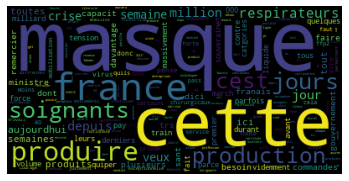

In [80]:
wordcloud2('discoursmacron31mars')

In [81]:
# WordCloud généré par le score tfidf obtenu avec la fonction

def wordcloud3(discours, corpus):
    frequencies = tfidf_dictionary(discours, corpus)
    wordcloud = WordCloud(max_font_size = 100)
    wordcloud.generate_from_frequencies(dict(frequencies))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

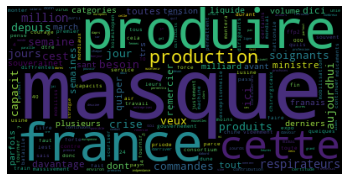

In [112]:
wordcloud3('discoursmacron31mars', 'corpusdiscoursmacron')

In [114]:
def wordcloud4(text, corpus):
    frequencies = tfidf_dictionary2(text, corpus)
    wordcloud = WordCloud(max_font_size = 100)
    wordcloud.generate_from_frequencies(frequencies)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

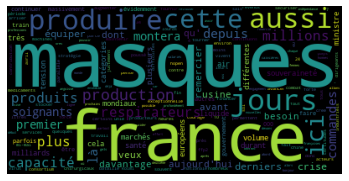

In [115]:
wordcloud4('discoursmacron31mars', 'corpusdiscoursmacron')

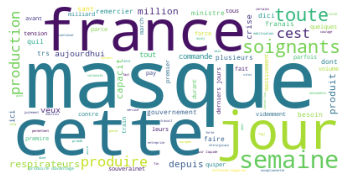

In [83]:
wordcloud1('discoursmacron31mars')

In [74]:
!pip install pywaffle
import matplotlib.pyplot as plt
from pywaffle import Waffle

In [75]:
import pandas as pd

def particular_word(word, text1, text2, text3):

# on veut dans data un dictionnaire où on a le texte en clé et le nombre d'occurence du mot en valeur
    texts = (text1, text2, text3)
    data = {}
    for k in texts:
        aux = sorted_dictionary2(dictionary(k))
        if word not in aux:
            data[k] = 0
        else:
            data[k] = aux[word]
            
# on veut représenter graphiquement l'évolution de la fréquence du mot dans le temps
    fig = plt.figure(
        FigureClass=Waffle, 
        rows=3, 
        values=data, 
        title={'label': f'Utilisation du mot "{word}" par les auteurs', 'loc': 'left'},
        labels=["{0} ({1})".format(k, v) for k, v in data.items()],
    );

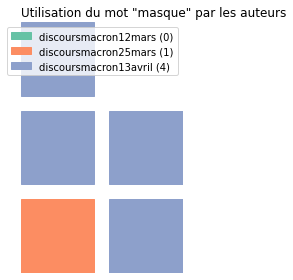

In [79]:
particular_word('masque', 'discoursmacron12mars', 'discoursmacron25mars', 'discoursmacron13avril')